This code automatically extracts features from any microscopy image without additional CNN model training. In this example, it is used to process multiple images to extract features, perform dimensionality reduction on extracted features, and used to train simpler machine learning models for predicting material properties.

In [1]:
import timm
import pretrainedmodels
import torch
from PIL import Image
from torchvision import transforms
import glob
from tqdm import tqdm
import pandas as pd


## Extract Features

In [2]:
# functions

def load_model(model_path):
    """Loading the model may be slow. Load once and pass each image seperately.

    Args:
        model_path (str): path to saved model. The download url for the model is 
        https://nasa-public-data.s3.amazonaws.com/microscopy_segmentation_models/se_resnext50_32x4d_pretrained_imagenet-microscopynet_v1.0.pth.tar

    Returns:
        pretrainedmodels.model: model pre-trained on MicroNet
    """
    model = timm.create_model('seresnext50_32x4d') 
    state_dict = torch.load(model_path)

    sditems = list(state_dict.items())
    for i, j in sditems:
        if i[:7] == 'layer0.':
            state_dict[i[7:]] = state_dict.pop(i)
        elif 'se_module' in i:
            state_dict[i.replace('se_module', 'se')] = state_dict.pop(i)
        elif 'last_linear' in i:
            state_dict[i.replace('last_linear', 'fc')] = state_dict.pop(i)

    model.load_state_dict(state_dict)

    if torch.cuda.is_available(): # move the model to GPU if available
        model.to('cuda')

    model.eval()
    return model

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
# load model
model_path = r'image_models\se_resnext50_32x4d_pretrained_imagenet-microscopynet_v1.0.pth.tar'
model = load_model(model_path)

In [4]:
# setup output dict
im_name_dict = {"image": []}
feature_dict = {"feature_%s"%i: [] for i in range(1000)}
output_dict = {**im_name_dict, **feature_dict}

In [5]:
# operate on images
img_dir = r'image_data\\'
for img_path in tqdm(glob.glob(img_dir + "*.tif")):
    # load and preprocess image
    im_name = img_path.split(img_dir[:-1])[1]
    input_image = Image.open(img_path).convert(mode='RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    input_batch = input_batch.to('cuda')

    # run inference (could speed up with batch inference)
    with torch.no_grad():
        output = model(input_batch)

    # add to dictionary
    o = output.cpu().detach().numpy()[0]
    output_dict['image'].append(im_name)
    [output_dict['feature_%s'%i].append(o[i]) for i in range(1000)];

100%|██████████| 1034/1034 [01:13<00:00, 14.02it/s]


In [ ]:
df = pd.DataFrame.from_dict(output_dict)
df.to_csv("latent_features_imagenet_microscopynet.csv", index=False)
df.head()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
# fred was here
# josh was here too

## Load data

In [ ]:
df_image_features = pd.read_csv('latent_features_imagenet_microscopynet.csv')
df_image_features.image = [name[:-4] for name in df_image_features.image] # drop the ".TIF"
df_meta = pd.read_csv('image_meta_data.csv')

In [ ]:
df_image_features.head()

In [ ]:
df_meta.head()

## Perform Data reduction

Questions.
1. What's the best method? PCA? TSNE?
2. How many features should it be reduced to? 50? 20?

Total variance explained: 0.95


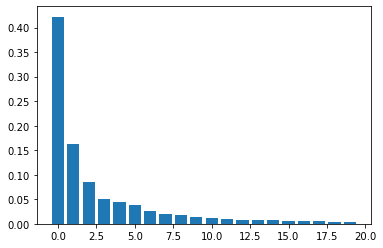

In [ ]:
NUM_FEATURES = 20
X = df_image_features.iloc[:, 1:].to_numpy()
pca = PCA(n_components=NUM_FEATURES)
X_reduced = pca.fit_transform(X)
plt.bar(x = range(NUM_FEATURES), height=pca.explained_variance_ratio_);
print("Total variance explained: %.2f"%(pca.explained_variance_ratio_.sum()))

## Combine data

In [ ]:
# Convert the PCA features to a dataframe
df_reduced = pd.DataFrame(X_reduced, columns=[f'PCA_{i}' for i in range(NUM_FEATURES)])

# Concat the image names with the pca features in a new dataframe
df_reduced_image_features = pd.concat([df_image_features['image'], df_reduced], axis=1)

df_reduced_image_features.head()

In [ ]:
# Combine meta data with reduced features
df = pd.merge(df_meta, df_reduced_image_features, left_on='specimen', right_on='image')

df.head()

### Build model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from visualize import plot_actual_versus_predicted

In [ ]:
features = [f'PCA_{i}' for i in range(NUM_FEATURES)]
target = 'UTS'

In [ ]:
# Split the data into input features and target variable
X = df[features]
y = df[target]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Calculate accuracy metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

C:\Users\jstuckne\AppData\Local\Temp\2\ipykernel_26368\2251678845.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Mean Squared Error: 4.54
R-squared: 0.56


In [ ]:
# predict on train data for plotting
y_train_pred = rf_model.predict(X_train)

# convert to numpy
y_test_np = np.array(y_test).ravel()
y_train_np = np.array(y_train).ravel()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actual_versus_predicted(y_test_pred, y_test, y_train_pred, y_train, title=None, save_fig=False):

    plt.figure(figsize=(10,10))
    conc = np.concatenate((y_test_pred, y_test, y_train_pred, y_train))
    std = conc.std()
    min_lim = min(conc) - std
    max_lim = max(conc) + std

    plt.xlim((min_lim, max_lim))
    plt.ylim((min_lim, max_lim))
    #plt.scatter(y_test, y_pred, alpha=0.5)
    plt.errorbar(y_train, y_train_pred, alpha=0.5, fmt='o', ecolor='lightgray', label='Train Split', ms=10)
    plt.errorbar(y_test, y_test_pred, alpha=0.5, fmt='o', ecolor='lightgray', label = 'Test Split', ms=10)
    plt.legend()
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.plot((min_lim, max_lim), (min_lim, max_lim), 'r-')
    if title is not None:
        plt.title(title)
    if save_fig:
        plt.tight_layout()
        plt.savefig('pred.png')
        plt.close()
    else:
        plt.show()

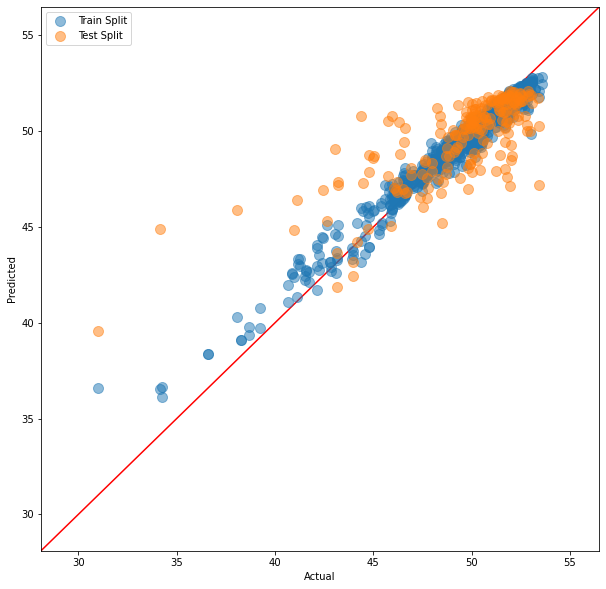

In [ ]:
plot_actual_versus_predicted(y_pred, y_test_np, y_train_pred, y_train_np)